<a href="https://colab.research.google.com/github/justinfmccarty/CityEnergyAnalyst_bigmacc/blob/master/Calculate_Heat%2BCool_Periods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining Heating and Cooling Seasons

This notebook uses effective tempreature (Houghton and Yaglou, 1923) to calculate a sliding effective temperture for each day of the year and then detemrine where to bracket out heating and cooling seasons following Wang et al (2015).

*Houghten, F., Yaglou, C., 1923. Determining lines of equal comfort. ASHVE Trans. 29, 163–176.*

*Wang Y, Wang L, Liu Y, Ding P, Deng S, Long E. Defining air-conditioning and heating seasons based on human thermal perception and building energy efficiency. Urban Clim 2015;14:544–53. doi:10.1016/j.uclim.2015.09.008.*

In [6]:
import random
import numpy as np
import pandas as pd
import urllib.request
import zipfile


In [7]:
def epw_to_dataframe(weather_path):
    epw_labels = ['year', 'month', 'day', 'hour', 'minute', 'datasource', 'drybulb_C', 'dewpoint_C', 'relhum_percent',
                  'atmos_Pa', 'exthorrad_Whm2', 'extdirrad_Whm2', 'horirsky_Whm2', 'glohorrad_Whm2', 'dirnorrad_Whm2',
                  'difhorrad_Whm2', 'glohorillum_lux', 'dirnorillum_lux', 'difhorillum_lux', 'zenlum_lux', 'winddir_deg',
                  'windspd_ms', 'totskycvr_tenths', 'opaqskycvr_tenths', 'visibility_km', 'ceiling_hgt_m',
                  'presweathobs', 'presweathcodes', 'precip_wtr_mm', 'aerosol_opt_thousandths', 'snowdepth_cm',
                  'days_last_snow', 'Albedo', 'liq_precip_depth_mm', 'liq_precip_rate_Hour']
    df = pd.DataFrame(pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels).drop('datasource', axis=1))
    df['hour'] = df['hour'].astype(int)
    if df['hour'][0]==1:
        print('EPW file hours reduced from 1-24h to 0-23h')
        df['hour'] = df['hour'] - 1
    else:
        print('EPW file hours maintained at 0-23hr')

    df['minute'] = 0
    return df


def calcET(dbt,rh):
  effective_temp = dbt - 0.4*(1-rh)
  return effective_temp

def calcSET(effectivetemps):
  SETs = []
  for i in list(range(0,len(effectivetemps)-4)):
    SETdaily = (sum((effectivetemps[i],effectivetemps[i+1],effectivetemps[i+2],effectivetemps[i+3],effectivetemps[i+4])))/5
    SETs.append(SETdaily)
  return SETs

def createSET(dbt,rh):
  idx = pd.date_range(freq="h", start="2018-01-01", periods=365*24)
  data = pd.DataFrame(data={'dbt': dbt,
                            'rh': rh},
                      index=idx)
  data['eff_temp'] = data.apply(lambda x: calcET(x['dbt'],x['rh']), axis=1 )
  data_daily = data.resample('D').mean()

  efftemps = data_daily['eff_temp'].values.tolist()
  efftemps[365:369] = efftemps[0:4]

  data_daily['SET'] = calcSET(efftemps)
  return data_daily

In [8]:
url = 'http://climate.onebuilding.org/WMO_Region_4_North_and_Central_America/CAN_Canada/BC_British_Columbia/CAN_BC_Vancouver.Intl.AP.718920_CWEC.zip'
urllib.request.urlretrieve(url,'/content/yvr.zip')

zf = zipfile.ZipFile('/content/yvr.zip', 'r')
zf.extractall('/content/yvr')
zf.close()

In [36]:
# best to change out the use of ladybug epw module due to pandas 
pcic_path = '/content/MORPHED_ROLL21_TAS_RHS_CAN_BC_UBC_2041-2070_CWEC2016.epw'
epw_path = '/content/yvr/CAN_BC_Vancouver.Intl.AP.718920_CWEC.epw'
epw = epw_to_dataframe(pcic_path)
# df = lbp.DataFrame.from_epw(epw)
# df.head()
dbt_list = epw.drybulb_C.values
rh_list_percent = epw.relhum_percent.values

rh_list = []

for i in rh_list_percent:
  rh_list.append(i/100)

daily_data = np.round(createSET(dbt_list,rh_list),2)


EPW file hours reduced from 1-24h to 0-23h


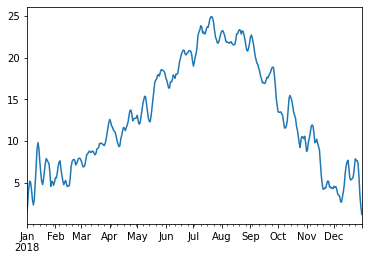

In [37]:
daily_data['SET'].plot.line()

In [38]:
def calc_above(value, threshold):
  if value > threshold:
    return 1
  else:
    return 0

def calc_below(value, threshold):
  if value < threshold:
    return 1
  else:
    return 0

cooling = 22
heating = 10

daily_data['above'] = daily_data.apply(lambda x: calc_above(x['SET'],cooling),axis=1)
daily_data['below'] = daily_data.apply(lambda x: calc_below(x['SET'],heating),axis=1)

daily_data['above_grp'] = (daily_data.above.diff(1) != 0).astype('int').cumsum()
daily_data['below_grp'] = (daily_data.below.diff(1) != 0).astype('int').cumsum()
daily_data['Date'] = daily_data.index

df_above = pd.DataFrame({'BeginDate' : daily_data.groupby('above_grp').Date.first(), 
              'EndDate' : daily_data.groupby('above_grp').Date.last(),
              'Consecutive' : daily_data.groupby('above_grp').size()}).reset_index(drop=True)


df_below = pd.DataFrame({'BeginDate' : daily_data.groupby('below_grp').Date.first(), 
              'EndDate' : daily_data.groupby('below_grp').Date.last(),
              'Consecutive' : daily_data.groupby('below_grp').size()}).reset_index(drop=True)



In [46]:
def above_below(value):
  if value==1:
    return 'Yes'
  else:
    return 'No'

daily_data['above'][0]



0